In [46]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph
from langgraph.errors import NodeInterrupt
from langgraph.checkpoint.memory import MemorySaver

reducer = lambda left, right: left + right

class State(TypedDict):
    inputs: Annotated[list[str], reducer]

def node_b(x):
    if(x['inputs'][-1] == 'Hello'):
        raise NodeInterrupt(f"Node B interrupted with {x['inputs'][-1]}")
    else:
        return { "inputs": ['Not modified by B'] }

def node_c(x):
    return { "inputs": ['Modified by C'] }


builder = StateGraph(State)
builder.add_node("A", lambda x: { "inputs": ['Modified by A'] })
builder.add_node("B", node_b)
builder.add_node("C", node_c)
builder.set_entry_point("A")
builder.add_edge("A", "B")
builder.add_edge("B", "C")
builder.set_finish_point("C")

memory = MemorySaver()
graph = builder.compile(interrupt_after=['A'], checkpointer=memory)

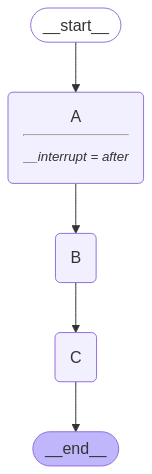

In [41]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
config = { 'configurable': { 'thread_id': 'dynamic_breakpoints' } }

graph.invoke({"inputs": ['Hello']}, config=config)

{'inputs': ['Hello',
  'Modified by A',
  'Hello',
  'Modified by A',
  'Hello',
  'Modified by A',
  'Hello',
  'Modified by A',
  'Hello',
  'Modified by A']}

In [56]:
values = graph.get_state(config=config).values

In [57]:
for event in graph.stream(None, config=config):
    print(event)


{'B': {'inputs': ['Not modified by B']}}
{'C': {'inputs': ['Modified by C']}}
